## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Loading Datasets

_TURKEY EARTHQUAKE_

In [3]:
data = pd.read_csv("datasets/eq.csv")
training_set = data.iloc[:, 4]
print(training_set)

0       4.4
1       5.2
2       4.8
3       4.4
4       5.7
       ... 
6569    4.5
6570    4.0
6571    4.4
6572    4.1
6573    4.0
Name: Magnitude, Length: 6574, dtype: float64


## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [4]:
t_diff = 1 # Daily Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

7.9
1       0.8
2      -0.4
3      -0.4
4       1.3
5      -1.4
       ... 
6569    0.4
6570   -0.5
6571    0.4
6572   -0.3
6573   -0.1
Name: Magnitude, Length: 6573, dtype: float64
2      -1.200000e+00
3       8.881784e-16
4       1.700000e+00
5      -2.700000e+00
6       1.100000e+00
            ...     
6569    1.500000e+00
6570   -9.000000e-01
6571    9.000000e-01
6572   -7.000000e-01
6573    2.000000e-01
Name: Magnitude, Length: 6572, dtype: float64


In [5]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0       0.8
1      -0.4
2      -0.4
3       1.3
4      -1.4
       ... 
6568    0.4
6569   -0.5
6570    0.4
6571   -0.3
6572   -0.1
Name: Magnitude, Length: 6573, dtype: float64
0      -1.200000e+00
1       8.881784e-16
2       1.700000e+00
3      -2.700000e+00
4       1.100000e+00
            ...     
6567    1.500000e+00
6568   -9.000000e-01
6569    9.000000e-01
6570   -7.000000e-01
6571    2.000000e-01
Name: Magnitude, Length: 6572, dtype: float64


In [6]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(6573,)
()


## Plot of the External Forcing from Chaotic Differential Equation (_Duffing Equation_)

<AxesSubplot:>

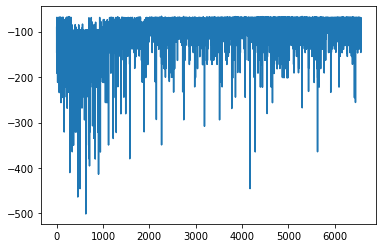

In [7]:
a=0.5
b=1
c=3
d=1
L = df.iloc[:, 2] -c + d*df.iloc[:, 1] - a*df.iloc[:, 0] - b*df.iloc[:, 0]**3
L.plot()

## Preprocessing the data into supervised learning

In [8]:
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg    

In [9]:
dat = Supervised(df.values, n_in = 10, n_out = 365)
dat.columns

Index(['var1(t-10)', 'var2(t-10)', 'var3(t-10)', 'var1(t-9)', 'var2(t-9)',
       'var3(t-9)', 'var1(t-8)', 'var2(t-8)', 'var3(t-8)', 'var1(t-7)',
       ...
       'var3(t+361)', 'var1(t+362)', 'var2(t+362)', 'var3(t+362)',
       'var1(t+363)', 'var2(t+363)', 'var3(t+363)', 'var1(t+364)',
       'var2(t+364)', 'var3(t+364)'],
      dtype='object', length=1125)

In [10]:
data = Supervised(df.values, n_in = 10, n_out = 365)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
       'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
       'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
       'var3(t-2)', 'var2(t-1)', 'var3(t-1)','var2(t-3)', 'var3(t-3)'], axis = 1, inplace = True)#,18,19
print(data.head())
print(data.columns)

    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10         4.4        5.2        4.8        4.4        5.7        4.3   
11         5.2        4.8        4.4        5.7        4.3        4.0   
12         4.8        4.4        5.7        4.3        4.0        4.8   
13         4.4        5.7        4.3        4.0        4.8        5.2   
14         5.7        4.3        4.0        4.8        5.2        5.1   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  ...  var3(t+361)  var1(t+362)  \
10        4.0        4.8        5.2        5.1  ...         -1.3          5.7   
11        4.8        5.2        5.1        4.7  ...          1.6          4.9   
12        5.2        5.1        4.7        4.6  ...         -1.1          5.7   
13        5.1        4.7        4.6        4.4  ...          0.1          5.4   
14        4.7        4.6        4.4        4.7  ...          0.1          5.2   

    var2(t+362)  var3(t+362)  var1(t+363)  var2(t+363)  var3(t+363)  \
10 

## Train and Test Split

In [11]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_1 = np.array(data[0:train_size])
test_1 = np.array(data[train_size:len(data)])
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train_1)
test = scaler.transform(test_1)
trainY = train[:,-9:]
trainX = train[:,:-9]
testY = test[:,-9:]
testX = test[:,:-9]
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(4958, 1, 1096) (4958, 9) (1240, 1, 1096) (1240, 9)


## Defining the Physical Loss

In [12]:
a = tf.Variable(0.5, name="alpha", trainable=True, dtype=tf.float32)
b = tf.Variable(1, name="beta", trainable=True, dtype=tf.float32)
c = tf.Variable(3, name="gamma", trainable=True, dtype=tf.float32)
d = tf.Variable(1, name="delta", trainable=True, dtype=tf.float32)


def phys(y_pred, y_true):
    return mean_absolute_error((y_true[:, 2] -c + d*y_true[:, 1] - a*y_true[:, 0] - b*y_true[:, 0]**3), (y_pred[:, 2] -c + d*y_pred[:, 1] - a*y_pred[:, 0] - b*y_pred[:, 0]**3))

def phys2(y_pred, y_real):
    pred = y_pred[2:]-2*y_pred[1:-1]-y_pred[:-2] -c + d*(y_pred[1:-1]-y_pred[:-2]) - a*y_pred[:-2] - b*y_pred[:-2]**3
    real = y_real[2:]-2*y_real[1:-1]-y_real[:-2] -c + d*(y_real[1:-1]-y_real[:-2]) - a*y_real[:-2] - b*y_real[:-2]**3
    return(mean_absolute_error(pred, real))

## Model

In [13]:
a = tf.Variable(0.1, name="alpha", trainable=True, dtype=tf.float32)
b = tf.Variable(0.05, name="beta", trainable=True, dtype=tf.float32)
c = tf.Variable(1.1, name="gamma", trainable=True, dtype=tf.float32)
d = tf.Variable(0.1, name="delta", trainable=True, dtype=tf.float32)

def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    squared_difference3 = tf.square(y_pred[:, 2] -c + d*y_pred[:, 1] - a*y_pred[:, 0] - b*y_pred[:, 0]**3)
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(9))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), shuffle=False)

Epoch 1/500
78/78 [==============================] - 3s 12ms/step - loss: 0.0220 - val_loss: 0.0087
Epoch 2/500
78/78 [==============================] - 0s 4ms/step - loss: 0.0159 - val_loss: 0.0083
Epoch 3/500
78/78 [==============================] - 0s 5ms/step - loss: 0.0170 - val_loss: 0.0084
Epoch 4/500
78/78 [==============================] - 0s 5ms/step - loss: 0.0169 - val_loss: 0.0084
Epoch 5/500
78/78 [==============================] - 0s 6ms/step - loss: 0.0166 - val_loss: 0.0083
Epoch 6/500
78/78 [==============================] - 0s 6ms/step - loss: 0.0164 - val_loss: 0.0083
Epoch 7/500
78/78 [==============================] - 0s 5ms/step - loss: 0.0162 - val_loss: 0.0083
Epoch 8/500
78/78 [==============================] - 0s 5ms/step - loss: 0.0160 - val_loss: 0.0082
Epoch 9/500
78/78 [==============================] - 1s 6ms/step - loss: 0.0156 - val_loss: 0.0083
Epoch 10/500
78/78 [==============================] - 0s 5ms/step - loss: 0.0153 - val_loss: 0.0082
Epoch 11

## Metrics

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

39/39 [==============================] - 1s 2ms/step
(1240, 9)
(1240, 1096)
Test RMSE: 2.865
Test MAE: 2.842
